# Assignment #2  20200045 Kimgeonwoo
- Fill in the blank cells below.
- Submit this notebook file via KLMS

## Predict  sales prices
- __Task 0__. Preliminary of assignment #2
<br>
- __Task 1__. Basic Linear regression    
    * Categorical Variable encoding
    * Remove columns with missing values
    * Linear regression and submit the result
- __Task 2__. Imputation    
    * Remove columns with missing values more than 20% 
    * Fill in remaining missing values
- __Task 3__. Linear regression with Regularization
    * Lasso
    * Ridge
- __Task 4__. EDA
    * Eyeballing on data
- __Task 5__. Feature engieering
    * Cardinal * Ordinal interaction
    * Caridnal * Nominal interaction
    * submit your best model

### Task 0. Preliminary

1.  Create your own Kaggle Account
    * https://www.kaggle.com
2.  Competition : House Prices - Advanced Regression Techniques
    * https://www.kaggle.com/c/house-prices-advanced-regression-techniques
    * This kaggle competition is to predict house price of Boston area.
3. Look-around the competition page
    * Code : useful sample codes 
        * Baseline, Pipeline, EDA (Exploratary Data Analysis), ...
    * Leaderboard
    * Discussions
    * Rules
    * Tutorials

4. Data download 
    * download data from `data` section of the competition
    * train.csv : data available for model developing
        - 81 columns, 1460 house records with label (SalePrice)
            * first column : row id 
            * last column : label ('SalePrice')
            * 79 features
        - need to split into train & validation data
            - train data : to train model parameters
            - val. data : to select model and hyper-parameters, to check performance
    * test.csv : __exam data__
        - 80 columns (no label), 1459 house records w/o label
        - you are supposed to fill in label (SalePrice) column by your prediction model
        - and submit it to kaggle to see your exam score and ranking in the leaderboard
    * Features : total 79 features available
        - Numeric
            * Cardinal: GrLivArea etc.
            * Ordinal: OverallQual etc. (1,2,...,10)
        - Categorical (Nominal): MSZoning etc.
        - Refer to `data_description.txt` in details
        - Note that there are many __missing values__

5. Evaluation measure
    - evaluation measure used in this competition : RMSE of log-price
    - use log of 'SalePrice' column as label
        * $p_i$ : SalePrice of data i
        * $y_i = \log p_i$ : label for data i (log price)
            * fit your model using MSE loss on log price
        * $\hat{y}_i$ : predicted log price
        * $\hat{p}_i = e^{\hat{y}_i}$ : Predicted price to be reported
    - similar effect as MAPE measure
        * $p = 10000, \hat{p} = 11000$ : 10% prediction error
            * $(p-\hat{p})^2 = (11000-10000)^2 = 1000^2 = 10^6$
            * $(\log_{10} p-\log_{10}\hat{p})^2 = (4.04139-4)^2 = 0.00171$
        * $p = 100000, \hat{p} = 110000$ : 10% prediction error
            * $(p-\hat{p})^2 = (110000-100000)^2 = 10000^2 = 10^8$
            * $(\log_{10} p-\log_{10}\hat{p})^2 = (5.04139-5)^2 = 0.00171$

### Task 1. Basic Linear regression  
- Let's try a 'quick' solution first.
- However, standard linear regression will not work:
    - missing values
    - categorical features
- Let's do minimal pre-processing and try linear regression in task 1.

In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings(action='ignore')

#### Task 1-1. Read data
- read 'train.csv' : pd.read_csv('train.csv', index_col=0)
     - make feature matrix (X_all) : do not include 'Id' column and 'SalePrice' column
     - make label vector (Y_all) : __log-price__ of 'SalePrice' column
- read 'test.csv' and make feature matrix (X_exam)
    - pd.read_csv('test.csv', index_col=0)
- check data : X_all, Y_all, X_exam
    - X_all.head() : show first 5 rows of X_all
    - X_all.info() : show columns and their data types, missing values, ...

In [124]:
# Task 1-1. fill-in this code cell 
from google.colab import drive
drive.mount('/content/drive')

train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/house-prices-advanced-regression-techniques/train.csv', index_col=0)
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/house-prices-advanced-regression-techniques/test.csv', index_col=0)

X_all = train.drop(['SalePrice'],axis=1)
Y_all = np.log(train[['SalePrice']])

X_exam = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/house-prices-advanced-regression-techniques/test.csv', index_col=0)

X_all.head()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


#### Task 1-2. Basic preprocessing
- X_all.info() shows that there are many columns with __missing values__
    - as a simples way to handle missing values, let's remove columns with missing values
        * use df.dropna(axis=1) : this will remove columns with any missiing values
    - note that some important information is thrown away 
        * we will recover this later
- X_all contains __ordinal variables__ whose values are {'Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'}
    - Excellent, Good, Typical/Average, Fair, Poor, Not Available
    - convert this into integer {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}
    - ordinal columns are : 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', ...
- X_all contains __categorical variables__
    - introduce one-hot binary variables (dummy variables)
    - method 1 : use pd.get_dummies(X_all)
    - method 2 : sklearn.preprocessing.OneHotEncoder
    
- Apply the aboves to X_exam data?
    - applying dropna and get_dummies to train data and exam data independently will result in different column sets
        * X_all.dropna(axis=1) $\to$ 60 columns remaning
        * X_exam.dropna(axis=1) $\to$ 46 columns remaning
        * If we drop all columns with NaN in either X_all or X_exam : only 45 columns will remain
    - concatenate X_all and X_exam, then apply dropna and get_dummies, then split
        * concat : df = pd.concat([df1, df2], axis=0) $\to$ vertically stack df1 and df2
        * split : df1 = df.iloc[:1000, :] $\to$ get first 1000 rows of df 
            * use `split_train_exam`() function

In [ ]:
def split_train_exam(X_combined, n):
    X_task = X_combined.iloc[:n,:]
    X_exam = X_combined.iloc[n:,:]
    return X_task, X_exam

In [ ]:
ordinal_map = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0, np.nan:np.nan}

def ordinal_int_encoding(X, ord_cols):
    for c in ord_cols:
        if c not in X.columns:
            continue
        X[c] = X[c].map(ordinal_map)
        X.rename(columns = {c : f'{c}_num'}, inplace = True)
    return X

In [108]:
# Task 1-2. fill-in this code cell 
# outputs
#   X_task1 : feature matrix for task 1  (this matches with Y_all)
#   X_exam1 : exam set for task 1


ord_cols = { 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond','PoolQC'}

df = pd.concat([X_all,X_exam], axis=0)

df.dropna(axis=1, inplace=True)
df = pd.get_dummies(df)

X_task1, X_exam1 = split_train_exam(df,1460)


#### Task 1-3. The $1^{st}$ attempt
- Let's try linear regression using the data from task 1-2
    * use `LinearRegression`
    * model fitting and check performance : use model_fit_perf()
        * split train_test_split()
        * fit to training data (X_trn1, Y_trn1)
        * compute & print model performance with training data (X_trn1, Y_trn1)
            * `sklearn.metrics.r2_score`
            * `sklearn.metrics.mean_squared_error`
        * compute & print model performance with validation data (X_val1, Y_val1)
            * use model_perf()
        * cross validation score with all data (X_task1, Y_all)
            * use cross_val_perf()
- Expected result is as below:  (numbers may be slightly different. why?)
    * LinearRegression Training   R^2 score = 0.916, RMSE = 0.1175
    * LinearRegression Validation R^2 score = 0.856, RMSE = 0.1438
    * LinearRegression Cross val. R^2 score mean = 0.844, std = 0.078

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score

# function to compute R^2 & RMSE and print them
# prefix : string to be printed at the front of a line
def model_perf(model, X, Y, prefix=''):
    Yhat = model.predict(X)
    r2 = r2_score(Y, Yhat)
    rmse = mean_squared_error(Y, Yhat, squared=False)
    print (f'{prefix} R^2 score = {r2:.3f}, RMSE = {rmse:.4f}')

    
def model_fit_perf(model, X_all, Y_all, prefix=''):
    X_trn, X_val, Y_trn, Y_val = train_test_split(X_all, Y_all, test_size=0.2, random_state=4)
    model.fit(X_trn, Y_trn)
    model_perf(model, X_trn, Y_trn, f'{prefix} Training  ')
    model_perf(model, X_val, Y_val, f'{prefix} Validation')
    s = cross_val_score(model, X_all, Y_all, cv=10)
    print (f'{prefix} Cross val. R^2 score mean = {s.mean():.3f}, std = {s.std():.3f}')

In [ ]:
# Task 1-3. fill-in this code cell 

# make a model, fit, training performance, val. performance, cross val performance  

model1 = LinearRegression()
model_fit_perf(model1,X_task1,Y_all)



 Training   R^2 score = 0.916, RMSE = 0.1175
 Validation R^2 score = 0.856, RMSE = 0.1438
 Cross val. R^2 score mean = 0.844, std = 0.078


#### Task 1-4. Let's submit your $1^{st}$ attempt
- Predict price for exam data using the trained model
    * note that your prediction will give log-price
    * so, take `np.exp()` to get price
- Read 'sample_submission.csv' file
- Replace 'SalePrice' column with your prediction price
- Write to 'mysub.csv' file
- Submit your result to kaggle
    * Leaderboard tab $\to$ `Submit predictions` button
    * step 1 : drag and drop your 'mysub.csv' file
    * step 2 : describe your submission $\to$ write something here like "my professor is the best" 
    * click `make submission` button $\to$ you will get your exam score
    * ![image.png](attachment:a1a85b2c-8216-4295-8bef-1f39b847a1f0.png)
    * by clicking "jump to your position on the leaderboard", you can check your ranking
- Capture your ranking and attach it in the next cell

In [ ]:
# Task 1-4. fill-in this code cell 

Yhat_val = model1.predict(X_exam1)
Yhat_val = np.exp(Yhat_val)

submisson = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/house-prices-advanced-regression-techniques/sample_submission.csv',index_col='Id')

submisson['SalePrice'] = Yhat_val

submisson.to_csv('/content/drive/MyDrive/Colab Notebooks/house-prices-advanced-regression-techniques/mysub.csv',sep = ',', na_rep= 'Nan')

- Paste screen capture of your leaderboard ranking here for task 1-4
- replace the sample shown here
![image.png](attachment:deabef24-f4d2-4923-9bf2-6569cc1036c7.png)

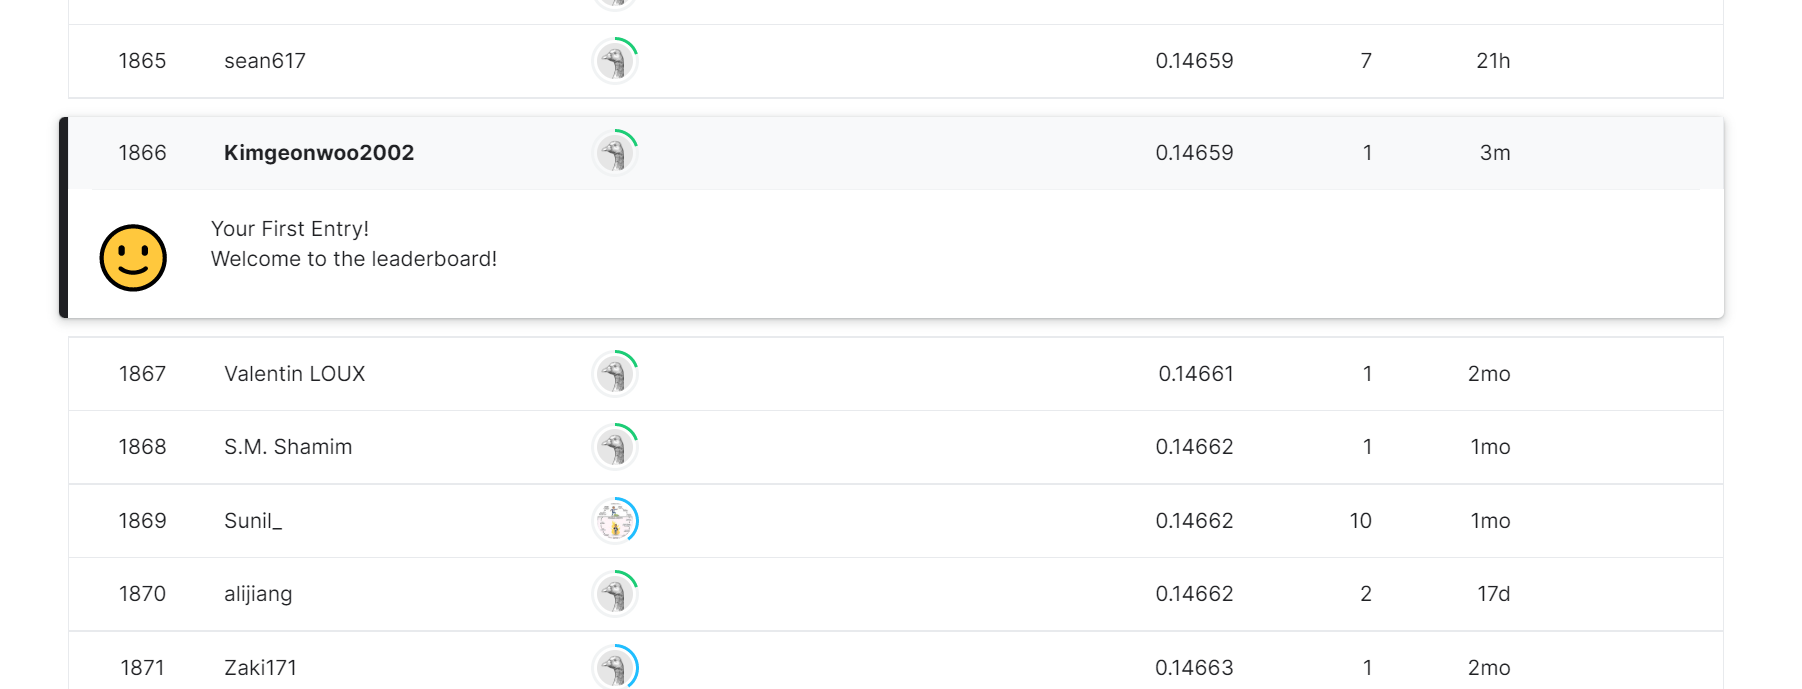

### Task 2. Imputation : filling missing values

- All columns with missing values were removed in task 1
    * 79 cols $\to$ 45 cols
    * some columns are missing in most of rows : PoolQC (7/1460 rows have values), ..
        * such columns should be removed
    * some columns carry meaningful value in most of rows : MasVnrType(1452), BsmtQual(1423), ...
        * we can do better with these columns
        * how to fill in missing values?
            * imputation : infer missing values from the known part of the data
            * sklearn.impute.SimpleImputer
                - numeric variable : 'mean' of the column, 'median' of the column, or 'constant'
                - categorical var. : 'most_frequent' category in the column, or 'constant'
            * sklearn.impute.IterativeImputer : more advance imputation for multi-feature

#### Task 2-1. Remove columns with many missing values (> 20%)
* vertically combine X_all and X_exam as X_combined
    - use pd.concat
* select columns with missing values portion larger than na_ratio=0.2
    - use keep_columns(X_all, X_exam, na_ratio)
    - which keeps columns with missing value portion <= na_ratio
* save as X_combined

In [ ]:
# this function keep columns with missing values less than na_ratio
def keep_columns(X_combined, na_ratio=0):
    X_null = X_combined.isnull().sum(axis=0)
    max_na = X_combined.shape[0] * na_ratio
    col = [c for c in X_combined.columns if X_null[c] <= max_na]
    return X_combined[col]

In [82]:
# Task 2-1 : remove columns with missing values more than 20%

X_all = train.drop(['SalePrice'],axis=1)
X_exam = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/house-prices-advanced-regression-techniques/test.csv', index_col=0)

X_combined = pd.concat([X_all,X_exam], axis=0)  #vertically combine X_all and X_exam as X_combined
X_combined = keep_columns(X_combined,0.2) #remove columns with missing values more than 20%

X_combined


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,61,0,0,0,0,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,42,0,0,0,0,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,35,272,0,0,0,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,84,0,0,0,0,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,21.0,1936,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,6,2006,WD,Normal
2916,160,RM,21.0,1894,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,24,0,0,0,0,0,4,2006,WD,Abnorml
2917,20,RL,160.0,20000,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,9,2006,WD,Abnorml


#### Task 2-2. select column names with numeric type and categorical type
* num_cols : numeric column name list, use X_combined.select_dtypes(include = np.number)
* cat_cols : categorical column name list, use X_combined.select_dtypes(include = 'object')

In [84]:
# Task 2-2 : select column names with numeric type and categorical type

num_cols = X_combined.select_dtypes(include = np.number).columns #  # of num_cols = 36
cat_cols = X_combined.select_dtypes(include = 'object').columns #   # of cat_cols = 38


#### Task 2-3. imputation 
- imputation : fill missing values using `sklearn.impute.SimpleImputer`
- make imputers
    * for numeric columns (num_cols) : fill with mean value of the column
        - num_imputer = SimpleImputer(strategy='mean')
    * for caterigorical columns (cat_cols) : fill with most frequent category in the column
        - cat_imputer = SimpleImputer(strategy='most_frequent')
- apply imputers to X_combined
    * apply num_imputer.fit_transform() to X_combined[num_cols]
        * and save result to X_combined[num_cols]

In [85]:
# Task 2-3 : make imputers and apply 
from sklearn.impute import SimpleImputer

num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')

X_combined[num_cols] = num_imputer.fit_transform(X_combined[num_cols])
X_combined[cat_cols] = cat_imputer.fit_transform(X_combined[cat_cols])

#### Task 2-4. encoding ordinal and categorical variables
- integer encoding for ordinal variables
    - use ordinal_int_encoding
- one-hot binary (dummy) encoding for convert categorical variables
    - use `pd.get_dummies`
- split X_combined into X_task2 and X_exam2
    - use split_train_exam

In [113]:
# Task 2-4 : dummy variables for categorical features
ordinal_int_encoding(X_combined, ord_cols)
X_combined = pd.get_dummies(X_combined)


X_task2, X_exam2 = split_train_exam(X_combined,1460)


#### Task 2-5. LinearRegression on imputed data
- apply LinearRegression
- fit model and check performance
    - use model_fit_perf()
        - data split into training and validation
        - fit model to training data
        - check training scores : use model_perf()
        - check validation scores : use model_perf()
        - cross validation performace

In [119]:
# Task 2-5 : LinearRegression model fitting and check performance

model2 = LinearRegression()
model_fit_perf(model2,X_task2,Y_all)


 Training   R^2 score = 0.946, RMSE = 0.0941
 Validation R^2 score = 0.861, RMSE = 0.1411
 Cross val. R^2 score mean = -479931.769, std = 1132893.749


#### Task 2-6. Is validation score (after imputation) better than Task 1-3?
- If yes, please submit your result to Kaggle
    * same as in Task 1-4.
    * include your exam score and ranking screen shot here
- If not, discuss why. (write your opinion here)
    * In my opinion, the validation score has increased because there occurs a bias in the model while filling in the missing values.
    * The na_ratio value of 0.2 was enough to raise Bias.

### Task 3. Regularization
- In this task, let's try L1, L2 regularization to avoid overfitting
    - Lasso
    - Ridge
    - ElasticNet

#### Task 3-1. Lasso
- Add L1 regularization
    * use Lasso
    * with default hyper-parameter alpha = 1
- fit & check performance
    * use model_fit_perf
- print the number of zeros and non-zeros in model.ceof_
- sample output
    * Lasso Training   R^2 score = 0.732, RMSE = 0.2091
    * Lasso Validation R^2 score = 0.792, RMSE = 0.1730
    * Lasso Cross val. R^2 score mean = 0.724, std = 0.122
    * \# of zero coefficients = 258, \# of non-zeros = 12

In [90]:
# Task 3-1 : Lasso model fitting and check performance
from sklearn.linear_model import Lasso, Ridge, ElasticNet

lasso = Lasso(alpha=1)

model_fit_perf(lasso,X_task2,Y_all)


# you should print coeffiecient

print('# of zero coefficients =',np.sum(lasso.coef_ == 0),'# of non-zeros =', np.sum(lasso.coef_ != 0))


 Training   R^2 score = 0.760, RMSE = 0.1981
 Validation R^2 score = 0.807, RMSE = 0.1667
 Cross val. R^2 score mean = 0.738, std = 0.187
# of zero coefficients = 230 # of non-zeros = 12


#### Task 3-2. Ridge
- Add L2 regularization
    * use Ridge
    * with default hyper-parameter alpha = 1
- do the same thing as in Task 2-1
    * fit & check performance : use model_fit_perf
    * print the number of zeros and non-zeros in model.ceof_

In [91]:
# Task 3-2 : Ridge model fitting and check performance

ridge = Ridge(alpha=1)

model_fit_perf(ridge,X_task2,Y_all)

print('# of zero coefficients =',np.sum(ridge.coef_ == 0),'# of non-zeros =', np.sum(ridge.coef_ != 0))


 Training   R^2 score = 0.936, RMSE = 0.1026
 Validation R^2 score = 0.890, RMSE = 0.1255
 Cross val. R^2 score mean = 0.868, std = 0.087
# of zero coefficients = 2 # of non-zeros = 240


#### Task 3-3. ElasticNet
- Add L1+L2 regularization
    * use ElasticNet
    * with default hyper-parameter alpha = 1
- do the same thing as in Task 2-1
    * fit & check performance : use model_fit_perf
    * print the number of zeros and non-zeros in model.ceof_

In [92]:
# Task 3-3 : ElasticNet model fitting and check performance

elnet = ElasticNet(alpha =1, l1_ratio=0.5)

model_fit_perf(elnet,X_task2,Y_all)

print('# of zero coefficients =',np.sum(elnet.coef_ == 0),'# of non-zeros =', np.sum(elnet.coef_ != 0))


 Training   R^2 score = 0.780, RMSE = 0.1895
 Validation R^2 score = 0.821, RMSE = 0.1602
 Cross val. R^2 score mean = 0.757, std = 0.176
# of zero coefficients = 227 # of non-zeros = 15


#### Task 3-4. Briefly compare results from Lasso, Ridge, ElasticNet
- Characteristics of Lasso
- Characteristics of Ridge
- Characteristics of ElasticNet

- We will optimize alpha hyper-parameter later.

In the case of Lasso, there are a lot of zero coefficients.

In the case of Ridge, there are a lot of non-zero coefficients.

In the case of ElasticNet, there a lot of zero coefficients but not as much as Lasso.

For R^2 score, Ridge is the best.

### Task 4. EDA (Exploratory Data Analysis)
- Eyeballing on data
- Grab some hints for feature engineering

#### Task 4-1. High correlation with SalePrice
- read 'train.csv' as XY_all
- Compute correlation between columns of XY_all 
    * use XY_all.corr()
    * sort in decreasing order or correlation with SalePrice
    * print result
- Select 6 most highly correlated features with SalePrice
    * store column names to `high_corr_cols`
    * print(high_corr_cols)
- Expected output:
    ![image.png](attachment:30c53a50-29e0-465b-badf-a20da02ba92a.png)

In [99]:
# Task 4-1 : correlation analysis

XY_all = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/house-prices-advanced-regression-techniques/train.csv', index_col=0)

df = pd.DataFrame(XY_all.corr())
df = df['SalePrice']
df = df.sort_values(ascending = False) #descending order
 
high_corr_cols = df[0:6].index

print('Correlation with SalePrice\n',df)
print('Top 6 features\n',high_corr_cols)

Correlation with SalePrice
 SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: Sale

#### Task 4-2. Scatter matrix of highly correlated features
- show scatter matrix using `pandas.plotting.scatter_matrix`
- as shown below
![image.png](attachment:6084366f-bc71-4ece-ae3f-c6cc0bbbb355.png)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe0ed785b10>,
      dtype=object)

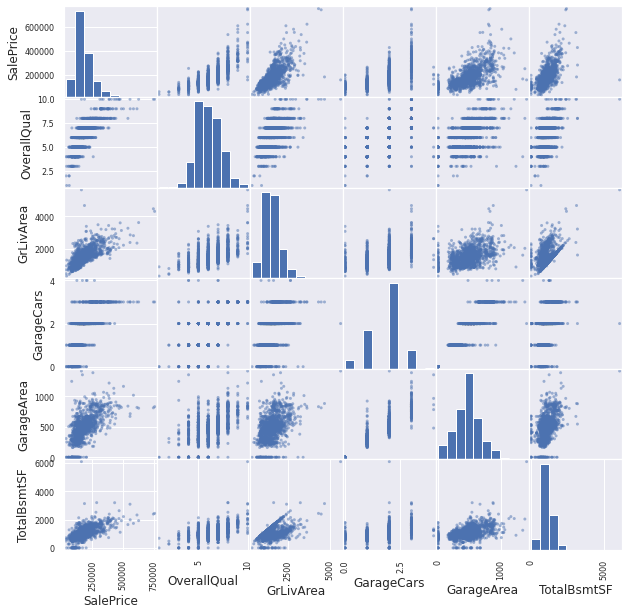

In [100]:
from pandas.plotting import scatter_matrix
# Task 4-2 : scatter matrix

df[high_corr_cols]

high_corr_XY = XY_all[high_corr_cols]

pd.plotting.scatter_matrix(high_corr_XY, figsize = (10,10))


### Task 5. Feature engineering and hyper-parameter tuning
- On top of model and data obtained so far
    * model : Ridge() will be used
    * data : removing some columns, imputation, one-hot encoding
- Add more feature to improve your model
    * interaction terms : product features
- Tuning hyper-parameter

#### Task 5-1. Interaction between GrLivArea, OverallQual
- We saw that `OverallQual` and `GrLivArea` have high correlation with SalePrice values.
    - OverallQual : overall quality score 1~10
    - GrLivArea : Ground livingroom area
- The effect of `OverallQual` and `GrLivArea` may not be additive
    * add a new feature = `OverallQual` * `GrLivArea`
        * an interaction feature
    * fit Ridge model and check performance
        * use model_fit_perf()
- You may add your own interaction features if you want

In [120]:
# Task 5-1 : interaction feature

X_combined['new'] = X_combined['OverallQual']*X_combined['GrLivArea'] 

X_combined_new = X_combined 

ordinal_int_encoding(X_combined_new, ord_cols)
X_combined_new = pd.get_dummies(X_combined_new)

X_task5, X_exam5 = split_train_exam(X_combined_new,1460)

model5_1 =Ridge()
model_fit_perf(model5_1,X_task5,Y_all)

 Training   R^2 score = 0.938, RMSE = 0.1010
 Validation R^2 score = 0.894, RMSE = 0.1236
 Cross val. R^2 score mean = 0.876, std = 0.069


#### Task 5-2. Grid Search to find best hyperparameter alpha
- As the final task, let's fine tune hyper-parameter alpha
- Ridge regression : penalize large $\mathbf{w}$ to avoid overfitting
    * min $ L(\textbf{w}) = (Y-X\mathbf{w})^2 + \alpha\mathbf{w}^2$
- How to choose $\alpha$?
    * use GridSearchCV
    * search $\alpha \in \{0, 0.5, 1, 1.5, ..., 20\}$
- fit `best_model` using $\alpha$ from the grid search result
    * model_fit_perf()

In [122]:
# Task 5-2. fill in this code cell 
from sklearn.model_selection import GridSearchCV

model5_2 = Ridge()

p_space = dict()
alpha = []
for i in range (41):
    alpha.append(i/2)

p_space['alpha'] = alpha

grid_search = GridSearchCV(model5_2, p_space, n_jobs=-1, cv=5)

grid_search.fit(X_task5, Y_all)

print(grid_search.best_params_['alpha'])

model5_2 = Ridge(alpha = grid_search.best_params_['alpha'])


model_fit_perf(model5_2, X_task5, Y_all)



10.5
 Training   R^2 score = 0.923, RMSE = 0.1124
 Validation R^2 score = 0.909, RMSE = 0.1141
 Cross val. R^2 score mean = 0.881, std = 0.070


#### Task 5-3. Submit the best model result
- Y_exam = best_model.pridict(X_exam5)
- Submit prediction result on exam data (X_exam5) as in Task 1-4.
- Capture your exam score and ranking here.

In [123]:
best_model = model5_2
Y_exam = best_model.predict(X_exam5)
Y_exam = np.exp(Y_exam)

submisson = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/house-prices-advanced-regression-techniques/sample_submission.csv',index_col='Id')

submisson['SalePrice'] = Y_exam

submisson.to_csv('/content/drive/MyDrive/Colab Notebooks/house-prices-advanced-regression-techniques/mysub2.csv',sep = ',', na_rep= 'Nan')

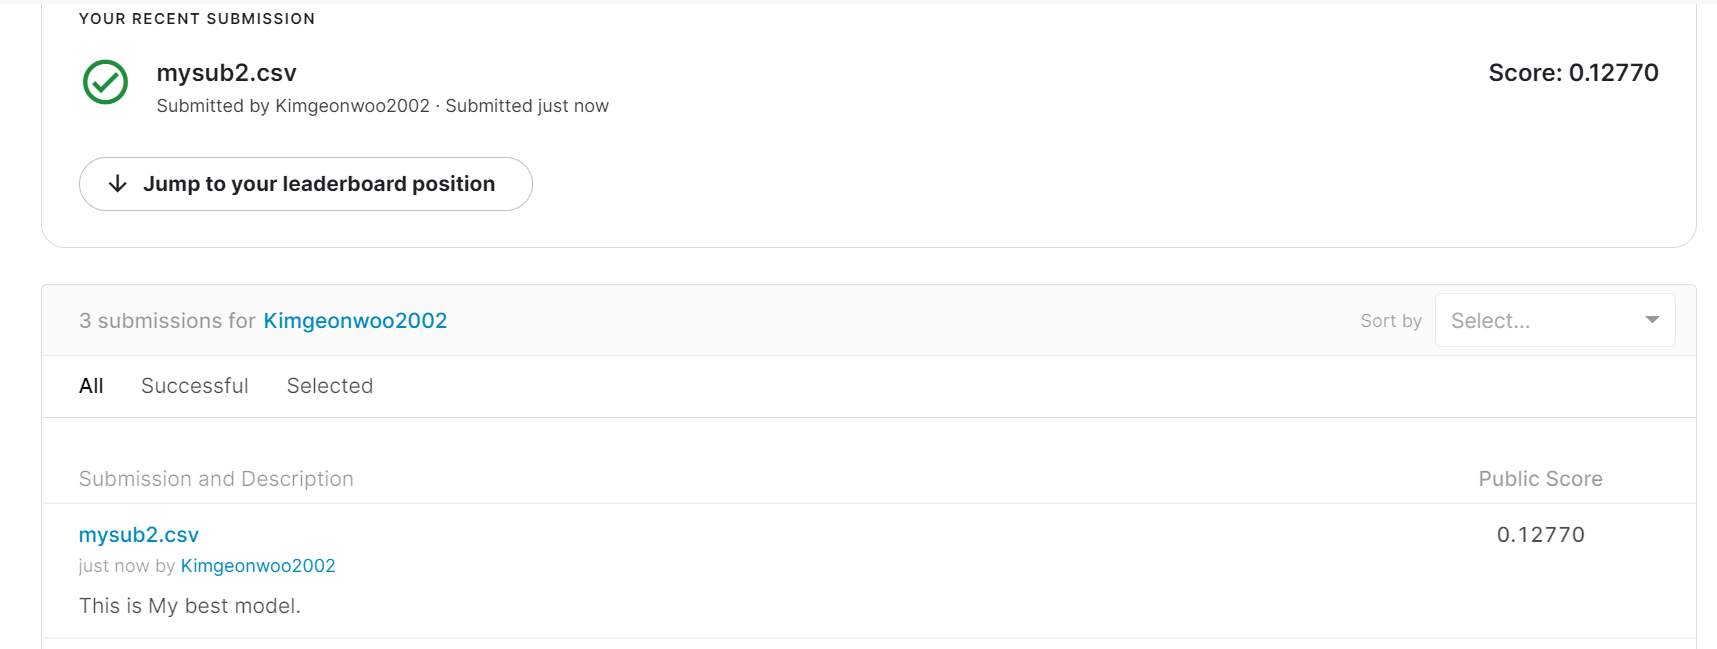

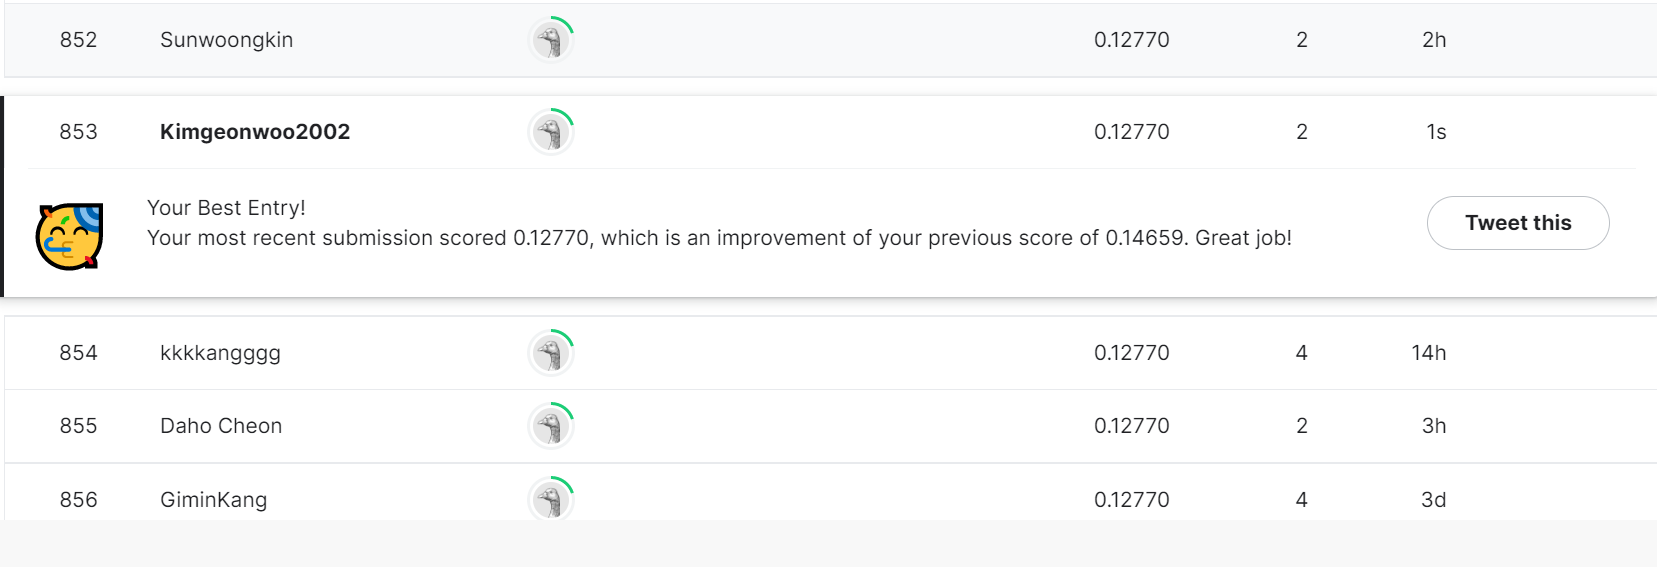